In [ ]:
# If running notebook online
# Make sure we've got the latest fastbook version
! pip install -Uqq fastbook dotenv

# If local - use 'kaggle' conda env

In [7]:
# Activate Notebook Specials
%matplotlib inline

In [1]:
# Import the fastai notebook library
import fastbook
fastbook.setup_book()

In [3]:
# Connect to MongoDB and retrieve image URLs and metadata
from pymongo import MongoClient
import pandas as pd
from dotenv import load_dotenv
import os

# Load the dotenv file
load_dotenv()

# Grab the MONGO_URI from local or from Kaggle
mongo_uri = os.getenv('MONGO_URI')
if not mongo_uri:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    mongo_uri = user_secrets.get_secret("MONGO_URI")

# Connect to the MongoDB client
client = MongoClient(mongo_uri)
 
# Access the database and collection
db = client['test']  # Replace with your database name
collection = db['cameratrapmedias']  # Replace with your collection name
 
# Query the collection to retrieve the first 150 records with image URLs, metadata, and the first index of 'relativePath'
data = list(collection.aggregate([
    {
        '$project': {
            '_id': 0,
            'publicURL': 1,
            'timestamp': 1,
            'relativePathSecond': { '$arrayElemAt': ['$relativePath', 1] }
        }
    },
    # { '$limit': 1500 }
]))
 
# Convert the data to a pandas DataFrame for exploration
df = pd.DataFrame(data)

# Select only the URLs and metadata for the first 150 records
df = df[['publicURL']]

# Export the small array to a CSV file for preview
df.to_csv('small_array.csv', index=False)
 
# Display the first few rows of the DataFrame
print(df.head())

                                                                                                                   publicURL
0                   https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0060.JPG
1  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0001.JPG
2  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0002.JPG
3  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0004.JPG
4  https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_Learnin_platform_camera_test/DCIM/100MEDIA/SYFW0006.JPG


Now that we have a connection to the MongoDB server and access to the URLs, let's use the `fastbook` library to simplify image handling and prepare for model inference.

In [ ]:
# Preview 4 images from the publicURL column using fastbook
from fastbook import *
from fastai.vision.widgets import *

# Create a directory to save the images
path = Path('images')
path.mkdir(exist_ok=True)

# Download and display a subset of 10 images for testing - found rat at 44410:44420
urls = df['publicURL'][44410:44420]
for i, url in enumerate(urls):
    # Download the image
    dest = path/f'image_{i}.jpg'
    # Since we're going to resize the image, we can download a smaller version in AWS and avoid overhead
    download_url(f'{url}?width=480&height=480', dest, show_progress=False)


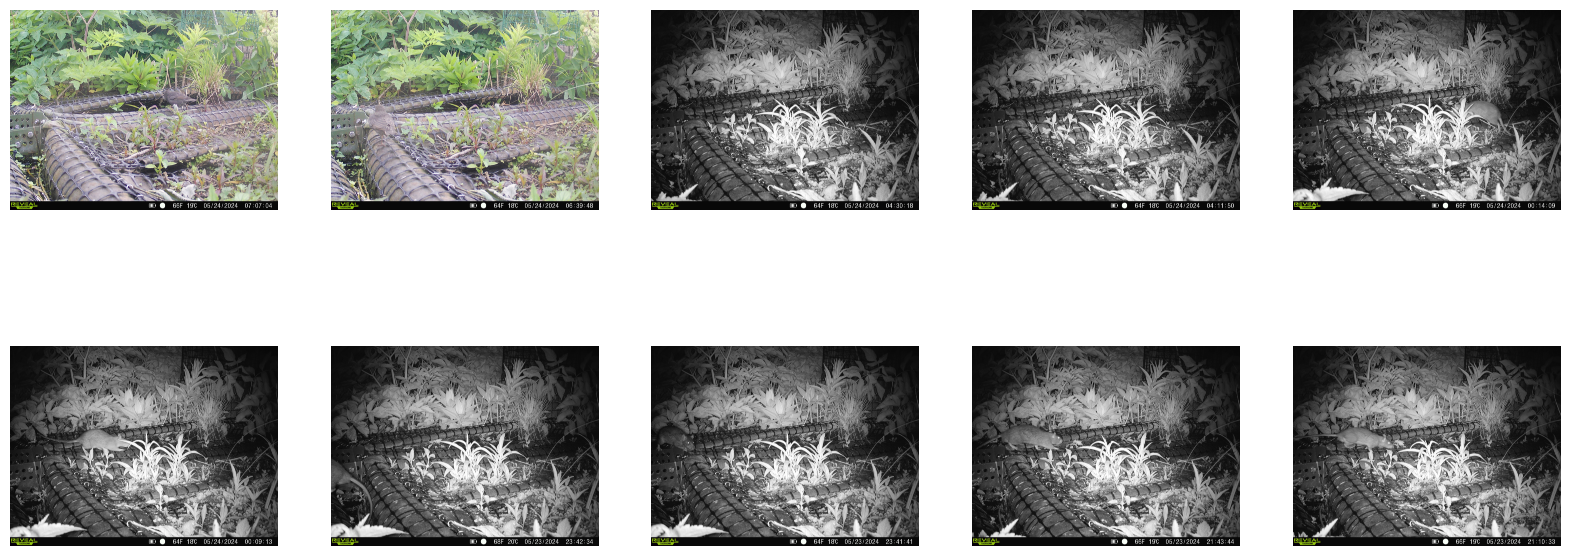

In [13]:

# Display the images using fastai utilities and a title with their image name
images = [PILImage.create(path/f'image_{i}.jpg') for i in range(10)]
show_images(images, nrows=2, ncols=5, figsize=(20, 8))


We clearly have the ability to access the URLs and index through images - now there are two paths to take
1. Try using the full image Google speciesnet model (v4.0.1b) as is - pre processing these images by vertical cropping top and bottom into right size (480x480px)